# Summarize models

This notebook summarizes all metrics required for model comparison including the following:

  1. Standardized predictor distributions
  1. Model residuals by predictor
  1. Forecast errors overall and by timepoint
  1. Model coefficients averages and by timepoint

## Import and define functions

In [558]:
import Bio.SeqIO
from collections import defaultdict
import glob
import json
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [559]:
#sns.set_style("ticks")
plt.style.use("huddlej")

In [560]:
!pwd

/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses


In [561]:
def mean_absolute_error(observed, estimated, **kwargs):
    """
    Calculates the mean absolute error between observed and estimated values.

    Parameters
    ----------
    observed : numpy.ndarray
        observed values

    estimated : numpy.ndarray
        estimated values

    Returns
    -------
    float :
        mean absolute error between observed and estimated values
    """
    return np.mean(np.abs(observed - estimated))

def root_mean_square_error(observed, estimated, **kwargs):
    """
    Calculates the root mean square error between observed and estimated values.

    Parameters
    ----------
    observed : numpy.ndarray
        observed values

    estimated : numpy.ndarray
        estimated values

    Returns
    -------
    float :
        root mean square error between observed and estimated values
    """
    return np.sqrt(np.mean((observed - estimated) ** 2))

def mean_square_error(observed, estimated, **kwargs):
    """
    Calculates the mean square error between observed and estimated values.

    Parameters
    ----------
    observed : numpy.ndarray
        observed values

    estimated : numpy.ndarray
        estimated values

    Returns
    -------
    float :
        mean square error between observed and estimated values
    """
    return np.mean((observed - estimated) ** 2)

def facet_time_plot(data, value, value_label, timepoint_column="timepoint", predictors_column="predictors", hue=None):
    g = sns.FacetGrid(data, col=predictors_column, col_wrap=4, hue=hue, height=4)
    g.map_dataframe(sns.lineplot, x=timepoint_column, y=value, estimator="mean", ci="sd", markers=True, dashes=False,
                   style=predictors_column)
    g.set_axis_labels("Date", value_label)

    for ax in g.axes.flatten():
        ax.axhline(y=0, color="#cccccc")

        #start, end = [int(value) for value in ax.get_xlim()]
        #end = end + 1
        #stepsize = 2.0
        #ax.xaxis.set_ticks(np.arange(start, end, stepsize))

        #labels = ax.get_xticklabels()
        #output = plt.setp(labels, rotation=30)
        
    plt.gcf().autofmt_xdate()
    return g

## Define configuration settings

In [562]:
predictor_names_order = [
    "naive",
    "delta_frequency",
    "lbi",
    "ep_x",
    "cTiterSub_x",
    "ne_star",
    "dms_star",
    "lbi-delta_frequency",
    "lbi-dms_star",
    "lbi-ep_x-ne_star"
]

In [563]:
data_root = "../results/builds/h3n2/20_viruses_per_month/sample_0/2000-10-01--2015-10-01/"

## Load data

In [564]:
tip_attributes_df = pd.read_table(data_root + "standardized_tip_attributes.tsv", parse_dates=["timepoint"])

In [565]:
tips_to_clades_df = pd.read_table(data_root + "tips_to_clades.tsv", parse_dates=["timepoint"])

In [566]:
model_jsons = glob.glob(data_root + "models/*.json")

In [567]:
models_by_predictors = {}

for model_json in model_jsons:
    with open(model_json, "r") as fh:
        data = json.load(fh)
        models_by_predictors["-".join(data["predictors"])] = data

In [568]:
models_by_predictors["lbi"]["cost_function"]

'sse'

In [569]:
models_by_predictors["lbi"]["l1_lambda"]

0.0

In [570]:
models_by_predictors["lbi"]["training_window"]

6

In [571]:
models_by_predictors.keys()

dict_keys(['lbi', 'delta_frequency', 'ep_x', 'naive'])

In [572]:
models_by_predictors["lbi"].keys()

dict_keys(['scores', 'predictors', 'cv_error_mean', 'cv_error_std', 'coefficients_mean', 'coefficients_std', 'cost_function', 'l1_lambda', 'delta_months', 'training_window', 'pseudocount'])

In [573]:
models_by_predictors["lbi"]["scores"][0].keys()

dict_keys(['predictors', 'training_data', 'training_n', 'training_error', 'coefficients', 'validation_data', 'validation_n', 'validation_error', 'last_training_timepoint', 'validation_timepoint'])

In [574]:
models_by_predictors["lbi"]["scores"][0]["training_n"]

1302

In [575]:
models_by_predictors["lbi"]["scores"][0]["validation_data"].keys()

dict_keys(['X', 'y', 'y_hat'])

In [576]:
models_by_predictors["lbi"]["scores"][0]["coefficients"]

[1.0888813881923203]

In [577]:
len(models_by_predictors["lbi"]["scores"])

7

Build data frames for plotting from the model scores.

In [578]:
overall_errors = []
errors_by_time = []
overall_coefficients = []
coefficients_by_time = []
frequency_dfs = []
residuals_dfs = []

for predictors, model in models_by_predictors.items():
    overall_errors.append({
        "predictors": predictors,
        "cv_error_mean": model["cv_error_mean"],
        "cv_error_std": model["cv_error_std"]
    })

    for predictor, mean, std in zip(model["predictors"], model["coefficients_mean"], model["coefficients_std"]):
        overall_coefficients.append({
            "predictors": predictors,
            "predictor": predictor,
            "mean": mean,
            "std": std
        })
    
    for scores in model["scores"]:
        errors_by_time.append({
            "predictors": predictors,
            "validation_timepoint": scores["validation_timepoint"],
            "validation_error": scores["validation_error"],
            "validation_n": scores["validation_n"]
        })
        
        for predictor, coefficient in zip(model["predictors"], scores["coefficients"]):
            coefficients_by_time.append({
                "predictors": predictors,
                "predictor": predictor,
                "coefficient": coefficient,
                "validation_timepoint": scores["validation_timepoint"]
            })
        
        X = pd.DataFrame(scores["validation_data"]["X"])
        X["timepoint"] = pd.to_datetime(X["timepoint"])
        y_init = X.groupby(["timepoint", "clade_membership"])["frequency"].sum().reset_index()
        
        y = pd.DataFrame(scores["validation_data"]["y"])
        y["timepoint"] = pd.to_datetime(y["timepoint"])

        y_hat = pd.DataFrame(scores["validation_data"]["y_hat"])
        y_hat["timepoint"] = pd.to_datetime(y_hat["timepoint"])

        frequency_df = y.merge(y_hat, on=["timepoint", "clade_membership"], suffixes=["", "_hat"])
        frequency_df = frequency_df.merge(y_init, on=["timepoint", "clade_membership"], suffixes=["", "_init"])
        frequency_df["residual"] = frequency_df["frequency"] - frequency_df["frequency_hat"]
        frequency_df["observed_growth_rate"] = frequency_df["frequency"] / frequency_df["frequency_init"]
        frequency_df["predicted_growth_rate"] = frequency_df["frequency_hat"] / frequency_df["frequency_init"]
        frequency_df["validation_timepoint"] = pd.to_datetime(scores["validation_timepoint"])
        frequency_df["predictors"] = predictors
        frequency_dfs.append(frequency_df)
        
        training_y = pd.DataFrame(scores["training_data"]["y"])
        training_y["timepoint"] = pd.to_datetime(training_y["timepoint"])
        training_y_hat = pd.DataFrame(scores["training_data"]["y_hat"])
        training_y_hat["timepoint"] = pd.to_datetime(training_y_hat["timepoint"])
        residual_df = training_y.merge(training_y_hat, on=["timepoint", "clade_membership"], suffixes=["", "_hat"])
        residual_df["residual"] = residual_df["frequency"] - residual_df["frequency_hat"]
        residual_df["validation_timepoint"] = pd.to_datetime(scores["validation_timepoint"])
        residual_df["predictors"] = predictors
        residuals_dfs.append(residual_df)

overall_errors_df = pd.DataFrame(overall_errors)
errors_by_time_df = pd.DataFrame(errors_by_time)
overall_coefficients_df = pd.DataFrame(overall_coefficients)
coefficients_by_time_df = pd.DataFrame(coefficients_by_time)
frequency_df = pd.concat(frequency_dfs, ignore_index=True)
residual_df = pd.concat(residuals_dfs, ignore_index=True)

In [579]:
training_y.head()

,clade_membership,frequency,timepoint
0,0003b07,0.000867,2007-10-01
1,01416f2,0.000867,2007-10-01
2,050242e,0.071316,2007-10-01
3,057451b,0.000867,2007-10-01
4,05ff466,0.000867,2007-10-01


In [580]:
training_y_hat.head()

,clade_membership,frequency,timepoint
0,0003b07,0.001451,2007-10-01
1,01416f2,0.011633,2007-10-01
2,050242e,0.012039,2007-10-01
3,057451b,0.000873,2007-10-01
4,05ff466,0.001045,2007-10-01


In [581]:
residual_df.head()

,clade_membership,frequency,timepoint,frequency_hat,residual,validation_timepoint,predictors
0,0296d71,0.000935,2004-10-01,0.000281,0.000654,2011-10-01,lbi
1,04064de,0.000935,2004-10-01,0.000237,0.000698,2011-10-01,lbi
2,089c686,0.000935,2004-10-01,0.003684,-0.002749,2011-10-01,lbi
3,094757b,0.000935,2004-10-01,0.000237,0.000698,2011-10-01,lbi
4,0f370ba,0.000935,2004-10-01,0.000180,0.000755,2011-10-01,lbi


In [582]:
residual_df.shape

(60340, 7)

In [583]:
frequency_df.head()

,clade_membership,frequency,timepoint,frequency_hat,frequency_init,residual,observed_growth_rate,predicted_growth_rate,validation_timepoint,predictors
0,00979d7,0.000864,2011-10-01,0.001833,0.011696,-0.000969,0.073863,0.156694,2011-10-01,lbi
1,00ca740,0.000864,2011-10-01,0.000415,0.002161,0.000449,0.399711,0.191986,2011-10-01,lbi
2,026e392,0.000864,2011-10-01,0.000091,0.002260,0.000773,0.382266,0.040373,2011-10-01,lbi
3,07a7c8d,0.000864,2011-10-01,0.000524,0.002218,0.000340,0.389510,0.236214,2011-10-01,lbi
4,09bc0a2,0.000864,2011-10-01,0.000433,0.005583,0.000431,0.154727,0.077541,2011-10-01,lbi


In [584]:
overall_errors_df.sort_values("cv_error_mean")

,cv_error_mean,cv_error_std,predictors
0,0.245239,0.102856,lbi
3,0.255101,0.109723,naive
2,0.257153,0.109076,ep_x
1,0.285173,0.127229,delta_frequency


In [585]:
errors_by_time_df.head()

,predictors,validation_error,validation_n,validation_timepoint
0,lbi,0.311743,166,2011-10-01
1,lbi,0.237244,221,2012-04-01
2,lbi,0.381300,224,2012-10-01
3,lbi,0.038776,168,2013-04-01
4,lbi,0.185248,180,2013-10-01


In [586]:
frequency_df.head()

,clade_membership,frequency,timepoint,frequency_hat,frequency_init,residual,observed_growth_rate,predicted_growth_rate,validation_timepoint,predictors
0,00979d7,0.000864,2011-10-01,0.001833,0.011696,-0.000969,0.073863,0.156694,2011-10-01,lbi
1,00ca740,0.000864,2011-10-01,0.000415,0.002161,0.000449,0.399711,0.191986,2011-10-01,lbi
2,026e392,0.000864,2011-10-01,0.000091,0.002260,0.000773,0.382266,0.040373,2011-10-01,lbi
3,07a7c8d,0.000864,2011-10-01,0.000524,0.002218,0.000340,0.389510,0.236214,2011-10-01,lbi
4,09bc0a2,0.000864,2011-10-01,0.000433,0.005583,0.000431,0.154727,0.077541,2011-10-01,lbi


## Summarize future frequencies per timepoint

In [587]:
(frequency_df.groupby(["predictors", "timepoint"])["frequency_init"].sum() > 0.9999).sum()

28

In [588]:
frequency_df.groupby(["predictors", "timepoint"])["frequency_init"].sum().shape

(28,)

In [589]:
(frequency_df.groupby(["predictors", "timepoint"])["frequency"].sum() > 0.9999).sum()

28

In [590]:
frequency_df[frequency_df["predictors"] == "lbi"].groupby(["timepoint"])["frequency"].sum()

timepoint
2011-10-01    1.0
2012-04-01    1.0
2012-10-01    1.0
2013-04-01    1.0
2013-10-01    1.0
2014-04-01    1.0
2014-10-01    1.0
Name: frequency, dtype: float64

(0.98, 1.01)

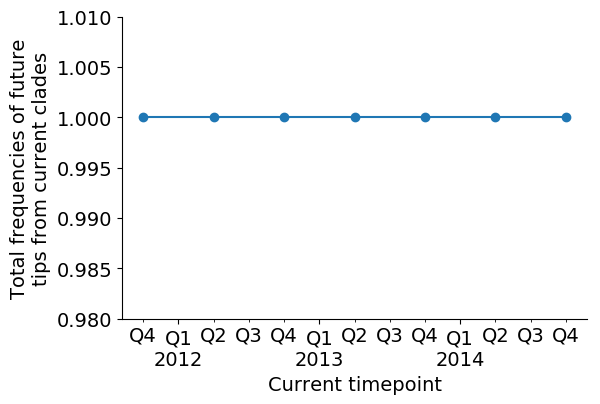

In [591]:
ax = frequency_df[frequency_df["predictors"] == "lbi"].groupby(["timepoint"])["frequency"].sum().plot(marker="o")
ax.set_xlabel("Current timepoint")
ax.set_ylabel("Total frequencies of future\ntips from current clades")
ax.set_ylim(0.98, 1.01)

## Inspect clade linkage between timepoints

Find out which clades assigned to tips per timepoint are present in the final timepoint.

In [592]:
tip_attributes_df.loc[:, ["strain", "timepoint", "clade_membership"]].head()

,strain,timepoint,clade_membership
0,A/Aichi/181/2004,2004-10-01,4ff1302
1,A/Aichi/183/2004,2004-10-01,b51374a
2,A/Anhui/789/2004,2004-10-01,213327e
3,A/Argentina/126/2004,2004-10-01,a18c764
4,A/Argentina/26/2004,2004-10-01,809d82c


In [593]:
tips_to_clades_df.head()

,tip,clade_membership,depth,lineage,segment,timepoint
0,A/Daegu/58/2001,9c5dfea,0,h3n2,ha,2004-10-01
1,A/Daegu/58/2001,2f661b6,2,h3n2,ha,2004-10-01
2,A/Canterbury/99/2000,caff4d6,0,h3n2,ha,2004-10-01
3,A/Canterbury/99/2000,9d101b5,1,h3n2,ha,2004-10-01
4,A/Canterbury/99/2000,9c5dfea,2,h3n2,ha,2004-10-01


In [594]:
clades_per_timepoint = tip_attributes_df.loc[:, ["timepoint", "clade_membership"]].drop_duplicates()

In [595]:
clades_per_timepoint.head()

,timepoint,clade_membership
0,2004-10-01,4ff1302
1,2004-10-01,b51374a
2,2004-10-01,213327e
3,2004-10-01,a18c764
4,2004-10-01,809d82c


In [596]:
clades_per_timepoint.tail()

,timepoint,clade_membership
7505,2015-10-01,a4d79d9
7507,2015-10-01,2bd1cf1
7509,2015-10-01,40ab968
7510,2015-10-01,970f785
7511,2015-10-01,1fb5adb


In [597]:
tips_to_clades_df.tail()

,tip,clade_membership,depth,lineage,segment,timepoint
1261769,A/Singapore/KK252/2015,8386d16,158,h3n2,ha,2015-10-01
1261770,A/Singapore/KK252/2015,9a3ff5d,160,h3n2,ha,2015-10-01
1261771,A/Singapore/KK252/2015,a5bcb4f,161,h3n2,ha,2015-10-01
1261772,A/Singapore/KK252/2015,aab80f6,164,h3n2,ha,2015-10-01
1261773,A/Singapore/KK252/2015,048f8ca,168,h3n2,ha,2015-10-01


In [598]:
tips_to_clades_df["timepoint"].max()

Timestamp('2015-10-01 00:00:00')

In [599]:
clades_present_at_last_timepoint = set(tips_to_clades_df.loc[
    tips_to_clades_df["timepoint"] == tips_to_clades_df["timepoint"].max(),
    "clade_membership"
].drop_duplicates().values)

In [600]:
list(clades_present_at_last_timepoint)[:5]

['c95ad95', 'ba96c70', '2426332', '8b685b8', '3f03e65']

In [601]:
len(clades_present_at_last_timepoint)

2926

In [602]:
clades_per_timepoint["present_at_last_timepoint"] = clades_per_timepoint["clade_membership"].apply(
    lambda clade: clade in clades_present_at_last_timepoint
)

In [603]:
clades_per_timepoint.head()

,timepoint,clade_membership,present_at_last_timepoint
0,2004-10-01,4ff1302,True
1,2004-10-01,b51374a,True
2,2004-10-01,213327e,True
3,2004-10-01,a18c764,True
4,2004-10-01,809d82c,True


Text(0,0.5,'Number of clades')

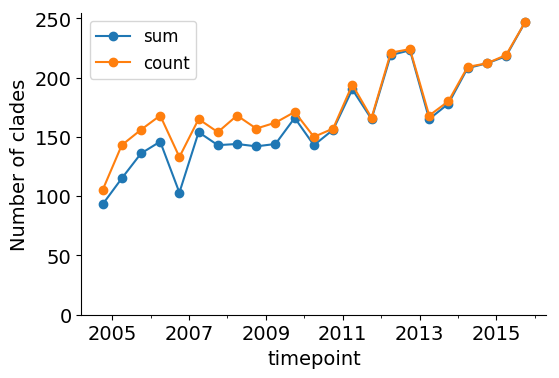

In [604]:
ax = clades_per_timepoint.groupby("timepoint")["present_at_last_timepoint"].aggregate(["sum", "count"]).plot(marker="o")
ax.set_ylim(bottom=0)
ax.set_ylabel("Number of clades")

In [605]:
counts_of_clades_per_timepoint = clades_per_timepoint.groupby("timepoint")["present_at_last_timepoint"].aggregate(["sum", "count"])

In [606]:
counts_of_clades_per_timepoint["missing"] = counts_of_clades_per_timepoint["count"] - counts_of_clades_per_timepoint["sum"]

Text(0,0.5,'Clades missing from final timepoint')

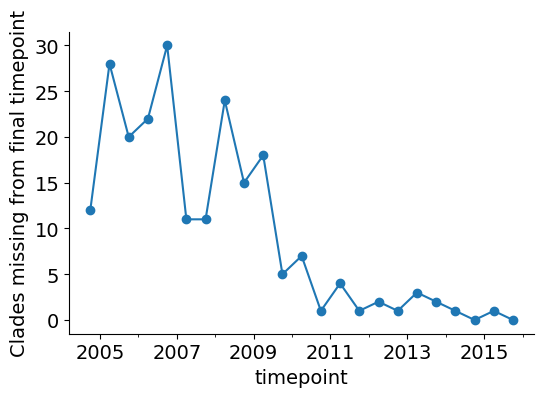

In [607]:
ax = counts_of_clades_per_timepoint["missing"].plot(marker="o")
ax.set_ylabel("Clades missing from final timepoint")

In [608]:
clades_per_timepoint[~clades_per_timepoint["present_at_last_timepoint"]].head()

,timepoint,clade_membership,present_at_last_timepoint
81,2004-10-01,4130399,False
83,2004-10-01,63088c4,False
92,2004-10-01,4b05874,False
93,2004-10-01,166a262,False
94,2004-10-01,f7ebd19,False


In [609]:
tip_attributes_df[(tip_attributes_df["timepoint"] == "2004-10-01") & (tip_attributes_df["clade_membership"] == "42c20f9")]

,strain,branch_length,cTiter,cTiterSub,cTiterSub_x,clade_membership,clock_length,country,country_entropy,dTiter,...,raw_date,rb,region,region_entropy,is_terminal,timepoint,lineage,segment,frequency,naive
14,A/Austria/144219/2004,0.000311,2.369531,1.976698,-1.07547,42c20f9,0.000311,austria,-1.000089e-12,0,...,2004-02-24,4,europe,-1.000089e-12,True,2004-10-01,h3n2,ha,0.012193,0.0


In [610]:
tips_to_clades_df[(tips_to_clades_df["tip"] == "A/Austria/144219/2004") & (tips_to_clades_df["depth"] == 0)]

,tip,clade_membership,depth,lineage,segment,timepoint
7191,A/Austria/144219/2004,42c20f9,0,h3n2,ha,2004-10-01
13801,A/Austria/144219/2004,5d23f35,0,h3n2,ha,2005-04-01
25030,A/Austria/144219/2004,42c20f9,0,h3n2,ha,2005-10-01
37591,A/Austria/144219/2004,42c20f9,0,h3n2,ha,2006-04-01
55642,A/Austria/144219/2004,42c20f9,0,h3n2,ha,2006-10-01
73804,A/Austria/144219/2004,42c20f9,0,h3n2,ha,2007-04-01
99479,A/Austria/144219/2004,01eabfc,0,h3n2,ha,2007-10-01
124483,A/Austria/144219/2004,42c20f9,0,h3n2,ha,2008-04-01
152598,A/Austria/144219/2004,42c20f9,0,h3n2,ha,2008-10-01
186368,A/Austria/144219/2004,42c20f9,0,h3n2,ha,2009-04-01


In [611]:
timepoints = tip_attributes_df["timepoint"].drop_duplicates()

In [612]:
# Get sequence for above strain from all amino acid translations per timepoint.
strain = "A/Austria/144219/2004"
strain_sequences = []
genes = ["SigPep", "HA1", "HA2"]

for timepoint in timepoints:
    sequence = ""
    for gene in genes:
        alignment_name = data_root + "timepoints/%s/segments/ha/aa-seq_%s.fasta" % (timepoint.strftime("%Y-%m-%d"), gene)
        with open(alignment_name, "r") as fh:
            records = Bio.SeqIO.parse(fh, "fasta")
            for record in records:
                if record.id == strain:
                    sequence += str(record.seq)
                    break

    strain_sequences.append(sequence)

In [613]:
len(strain_sequences)

23

In [614]:
for i in range(len(strain_sequences[0])):
    bases = set([sequence[i] for sequence in strain_sequences])
    if len(bases) != 1:
        print("%i: %s" % (i, bases))

376: {'T', 'I'}
499: {'E', 'G'}


In [615]:
strain_nucleotide_sequences = []
for timepoint in timepoints:
    json_name = data_root + "timepoints/%s/segments/ha/nt_muts.json" % timepoint.strftime("%Y-%m-%d")
    with open(json_name, "r") as fh:
        nt_muts = json.load(fh)
        strain_nucleotide_sequences.append(nt_muts["nodes"][strain]["sequence"])

In [616]:
len(strain_nucleotide_sequences)

23

In [617]:
len(set(strain_nucleotide_sequences))

6

In [618]:
for i in range(len(strain_nucleotide_sequences[0])):
    bases = set([sequence[i] for sequence in strain_nucleotide_sequences])
    if len(bases) != 1:
        print("%i: %s" % (i, bases))

1091: {'C', 'T'}
1127: {'C', 'A'}
1129: {'C', 'T'}
1187: {'A', 'G'}
1199: {'A', 'G'}
1211: {'C', 'A'}
1498: {'A', 'G'}


In [619]:
strain

'A/Austria/144219/2004'

## Summarize standardized predictor distributions

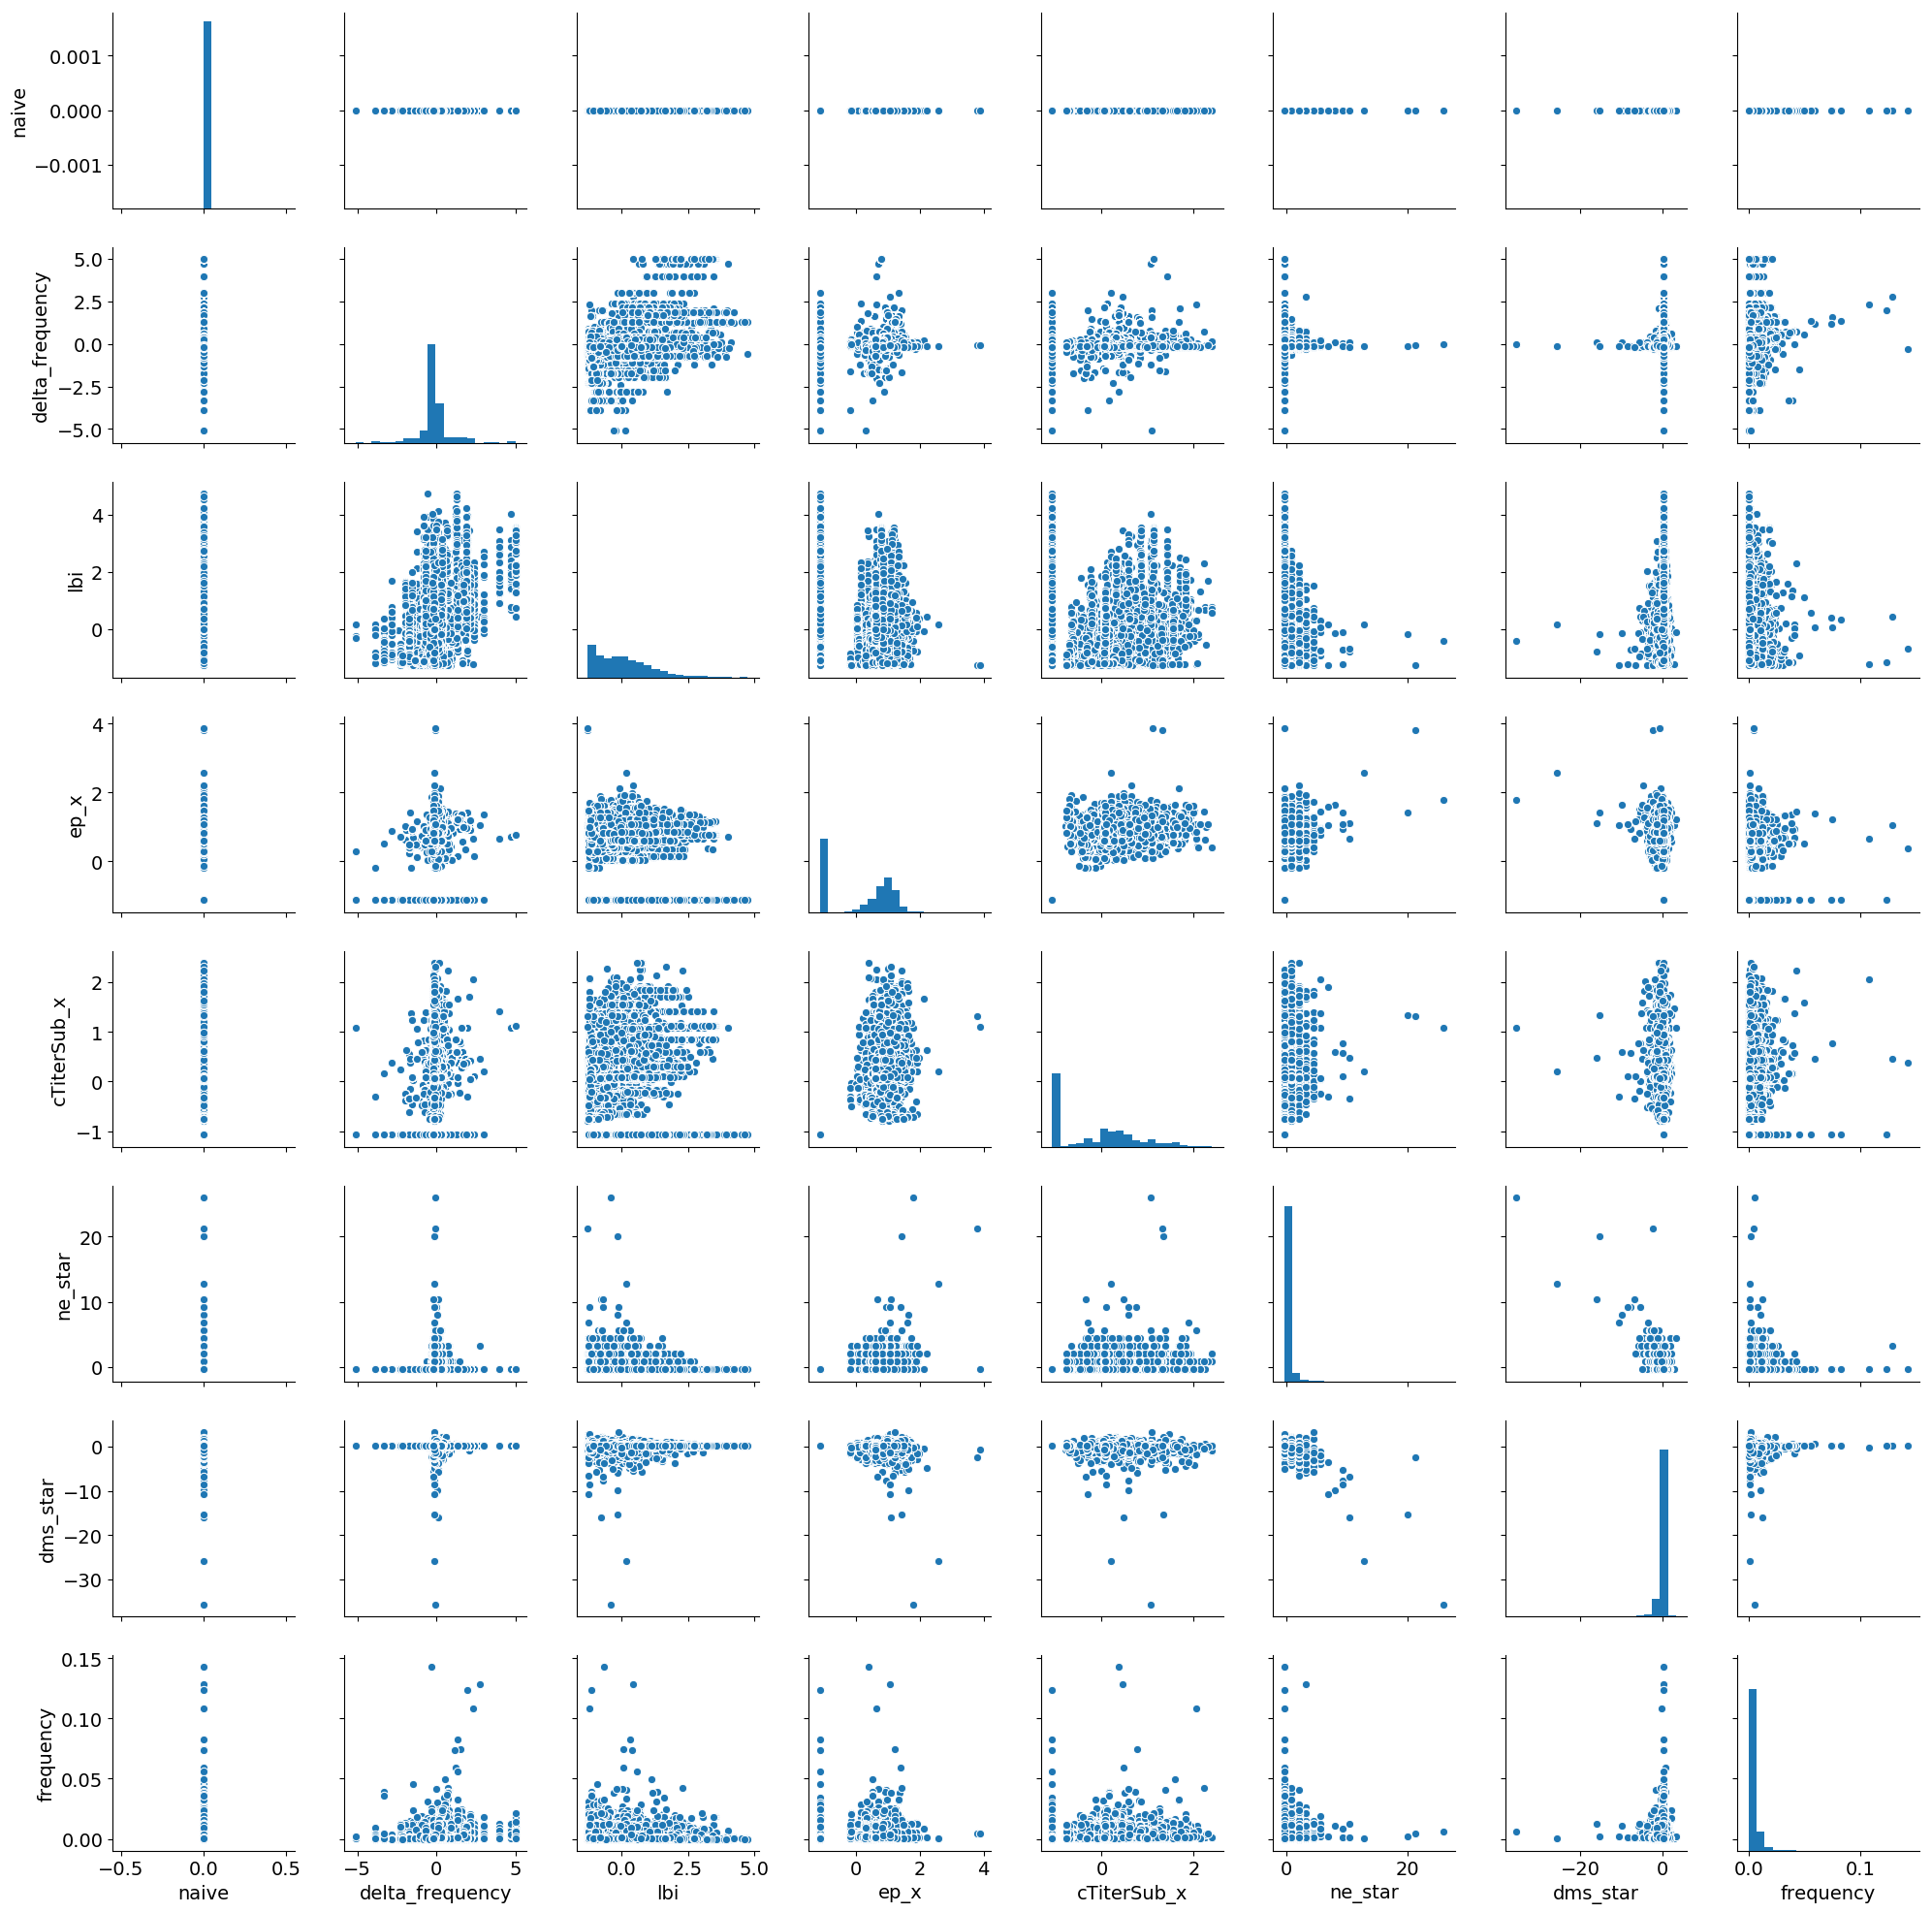

In [620]:
variables_to_plot = [predictor for predictor in predictor_names_order if not "-" in predictor] + ["frequency"]
sns.pairplot(tip_attributes_df, vars=variables_to_plot, diag_kind="hist", diag_kws={"bins": 20})

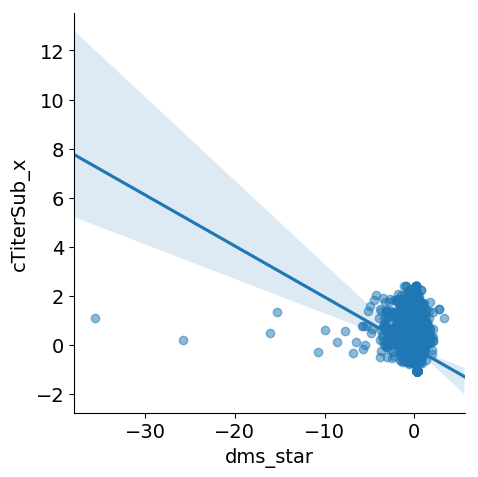

In [621]:
sns.lmplot("dms_star", "cTiterSub_x", tip_attributes_df, scatter_kws={"alpha": 0.5})

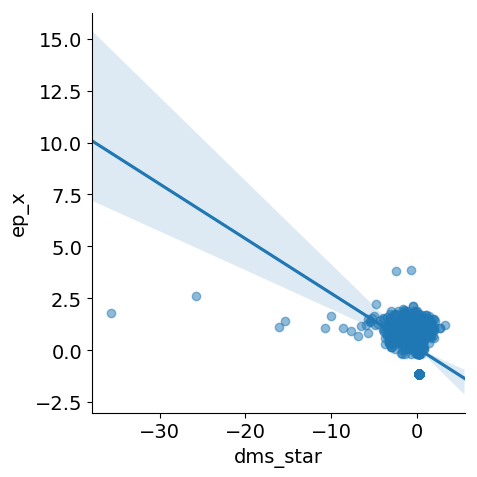

In [622]:
sns.lmplot("dms_star", "ep_x", tip_attributes_df, scatter_kws={"alpha": 0.5})

In [623]:
tip_attributes_df.loc[tip_attributes_df["dms_star"] < -15, ["timepoint", "strain", "cTiterSub_x", "ep_x", "dms_star", "frequency", "raw_date"]]

,timepoint,strain,cTiterSub_x,ep_x,dms_star,frequency,raw_date
1088,2006-10-01,A/India/Dib0622567/2006,0.485603,1.093418,-16.042506,0.012344,2006-06-27
1460,2007-04-01,A/Tehran/556/2007,1.074318,1.794944,-35.619862,0.005775,2007-02-26
3299,2010-10-01,A/HoChiMinh/6608/2010,1.336318,1.410461,-15.323551,0.001871,2010-08-22
6094,2014-04-01,A/Thailand/CU-CB166/2014,0.205485,2.582072,-25.780878,0.000825,2014-04-01


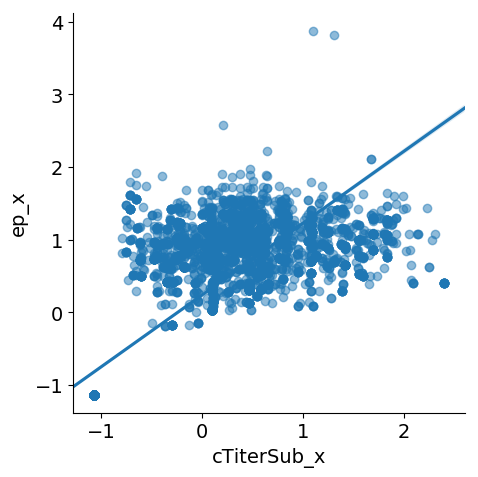

In [624]:
sns.lmplot("cTiterSub_x", "ep_x", tip_attributes_df, scatter_kws={"alpha": 0.5})

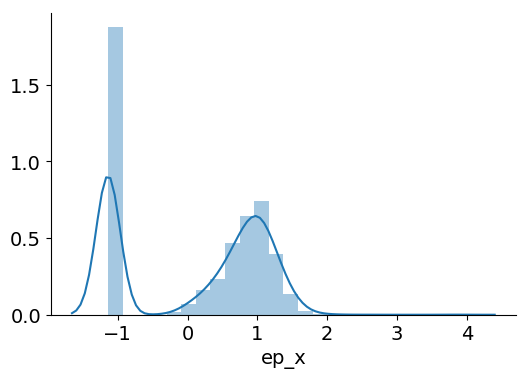

In [625]:
sns.distplot(tip_attributes_df["ep_x"])

In [626]:
tip_attributes_df["ep_x"].mean()

0.09024242920965865

In [627]:
raw_tip_attributes_df = pd.read_table(data_root + "tip_attributes.tsv")

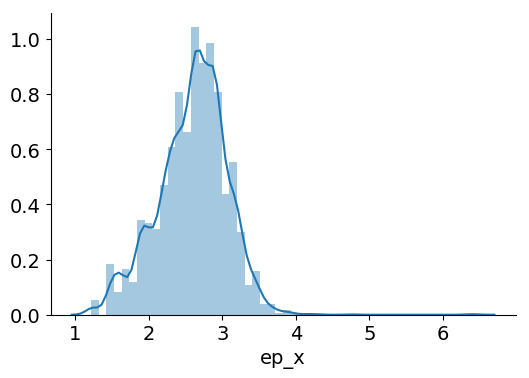

In [628]:
sns.distplot(raw_tip_attributes_df["ep_x"].dropna())

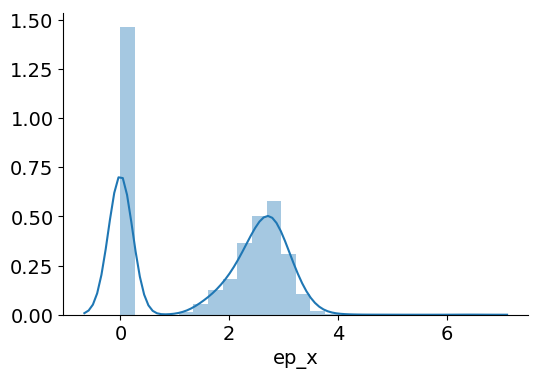

In [629]:
sns.distplot(raw_tip_attributes_df["ep_x"].fillna(0.0))

In [630]:
raw_tip_attributes_df["ep_x"].dropna().mean()

2.5934798726687682

In [631]:
raw_tip_attributes_df["ep_x"].dropna().std()

0.46896456334625297

In [632]:
raw_tip_attributes_df["ep_x"].fillna(0.0).mean()

1.5760430802360128

In [633]:
raw_tip_attributes_df["ep_x"].fillna(0.0).std()

1.318095246492442

## Summarize model residuals

In [634]:
residuals_by_timepoint = residual_df.groupby(["predictors", "timepoint"])["residual"].sum().reset_index()

In [635]:
residuals_by_timepoint.head()

,predictors,timepoint,residual
0,delta_frequency,2004-10-01,1.279359e-16
1,delta_frequency,2005-04-01,1.435484e-15
2,delta_frequency,2005-10-01,-9.853229e-16
3,delta_frequency,2006-04-01,1.908196e-16
4,delta_frequency,2006-10-01,-1.805522e-15


In [636]:
residuals_by_timepoint.groupby("predictors")["residual"].sum()

predictors
delta_frequency   -1.814022e-14
ep_x              -1.904455e-14
lbi               -1.631876e-14
naive             -2.078871e-14
Name: residual, dtype: float64

In [637]:
model_name = "lbi"

In [638]:
model_residuals_by_timepoint = residuals_by_timepoint[residuals_by_timepoint["predictors"] == model_name]

In [639]:
max_lags = 18

Text(0,0.5,'Number of clades')

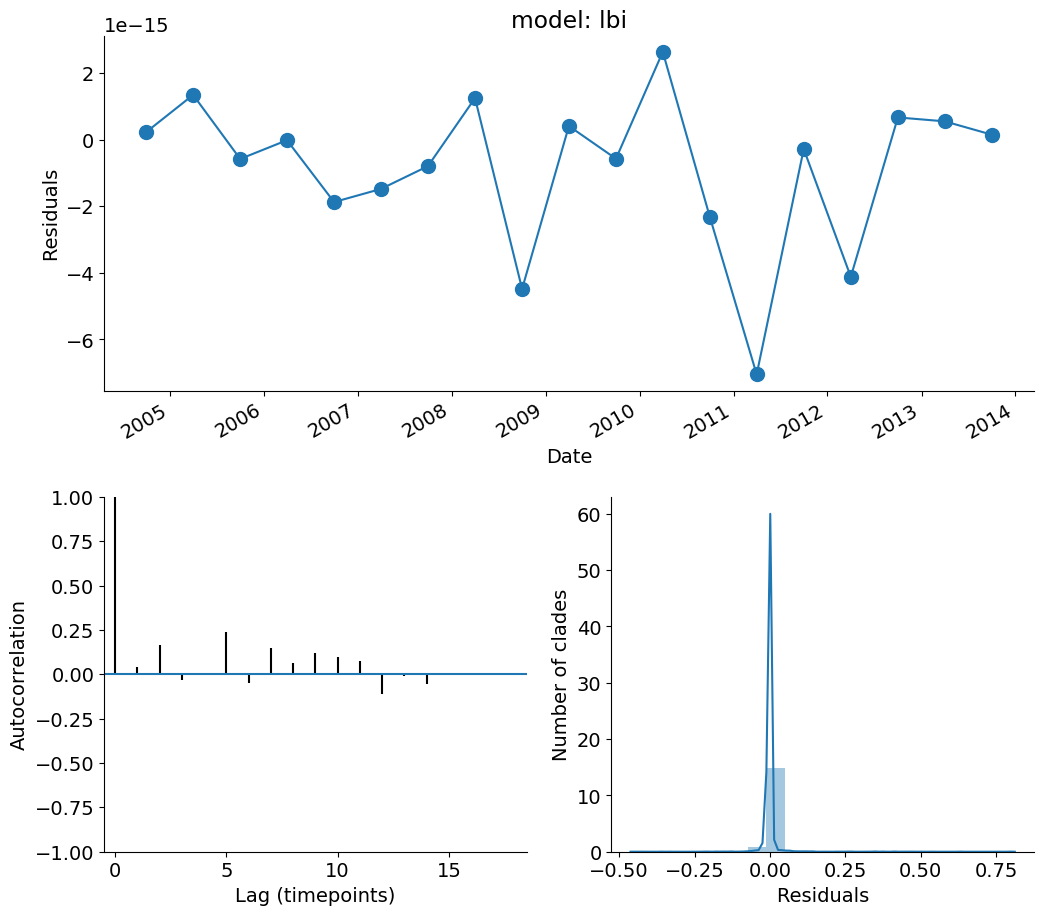

In [640]:
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 2)
gs.update(hspace=0.3)

ax1 = plt.subplot(gs[0, :])
ax1.plot(model_residuals_by_timepoint["timepoint"], model_residuals_by_timepoint["residual"], "o-", markersize=10)
ax1.set_xlabel("Date")
ax1.set_ylabel("Residuals")
ax1.set_title("model: %s" % model_name)
plt.gcf().autofmt_xdate()

ax2 = plt.subplot(gs[1, :-1])
max_lags = len(model_residuals_by_timepoint["residual"]) - 1
lags, autocorrelation, lines, horizonal_lines = ax2.acorr(
    model_residuals_by_timepoint["residual"],
    maxlags=max_lags
)
ax2.set_xlabel("Lag (timepoints)")
ax2.set_ylabel("Autocorrelation")
ax2.set_xlim(-0.5, max_lags + 0.5)
ax2.set_ylim(-1, 1)

ax3 = plt.subplot(gs[1:, -1])
sns.distplot(residual_df.loc[residual_df["predictors"] == model_name, "residual"], ax=ax3, bins=20)
ax3.set_xlabel("Residuals")
ax3.set_ylabel("Number of clades")

In [641]:
residual_df.head()

,clade_membership,frequency,timepoint,frequency_hat,residual,validation_timepoint,predictors
0,0296d71,0.000935,2004-10-01,0.000281,0.000654,2011-10-01,lbi
1,04064de,0.000935,2004-10-01,0.000237,0.000698,2011-10-01,lbi
2,089c686,0.000935,2004-10-01,0.003684,-0.002749,2011-10-01,lbi
3,094757b,0.000935,2004-10-01,0.000237,0.000698,2011-10-01,lbi
4,0f370ba,0.000935,2004-10-01,0.000180,0.000755,2011-10-01,lbi


### Residuals by predictor

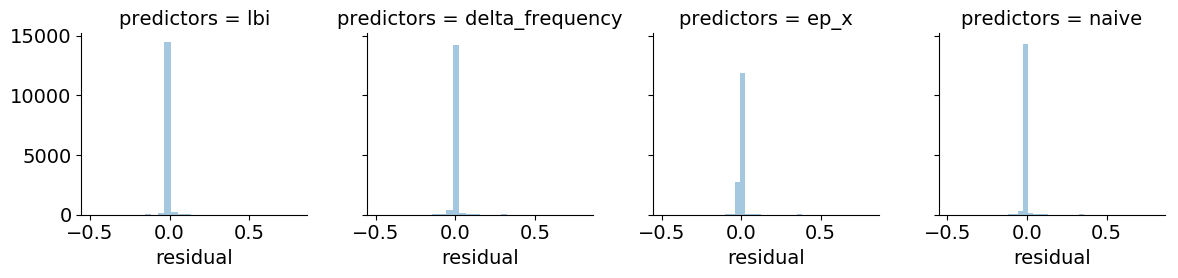

In [642]:
g = sns.FacetGrid(residual_df, col="predictors", col_wrap=4)
g.map(sns.distplot, "residual", bins=30, kde=False)

In [643]:
residual_df.groupby("predictors")["residual"].median().sort_values()

predictors
naive             -0.001347
ep_x              -0.001329
delta_frequency   -0.000719
lbi               -0.000353
Name: residual, dtype: float64

In [644]:
residual_df.groupby("predictors")["residual"].count()

predictors
delta_frequency    15085
ep_x               15085
lbi                15085
naive              15085
Name: residual, dtype: int64

In [645]:
(residual_df["residual"] < -0.01).sum()

5248

### Residuals by timepoint

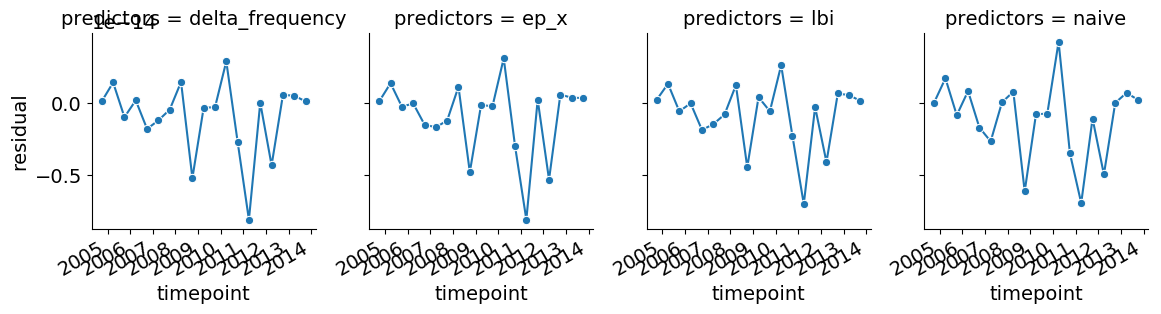

In [646]:
g = sns.FacetGrid(residuals_by_timepoint, col="predictors", col_wrap=4)
g.map(sns.lineplot, "timepoint", "residual", marker="o", linestyle="")
plt.gcf().autofmt_xdate()

In [647]:
np.abs(residuals_by_timepoint[residuals_by_timepoint["predictors"] == "lbi"]["residual"].values - residuals_by_timepoint[residuals_by_timepoint["predictors"] == "naive"]["residual"].values)

array([1.92554306e-16, 3.79037080e-16, 2.70291602e-16, 8.50014503e-16,
       1.64039789e-16, 1.19251397e-15, 8.50231344e-16, 4.57966998e-16,
       1.68073021e-15, 1.19695920e-15, 1.61762964e-16, 1.63562740e-15,
       1.19002030e-15, 7.19910243e-17, 8.04044331e-16, 8.60748105e-16,
       6.53123389e-16, 1.58293517e-16, 8.15320034e-17])

### Autocorrelation of residuals

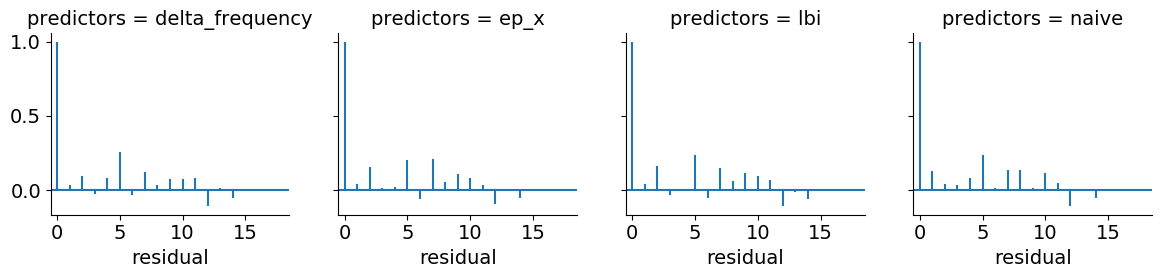

In [648]:
g = sns.FacetGrid(residuals_by_timepoint, col="predictors", col_wrap=4)
g.map(plt.acorr, "residual", maxlags=max_lags)

for ax in g.axes.flatten():
    ax.set_xlim(-0.5, max_lags + 0.5)

## Summarize observed and predicted frequencies and growth rates

### Observed and predicted frequencies

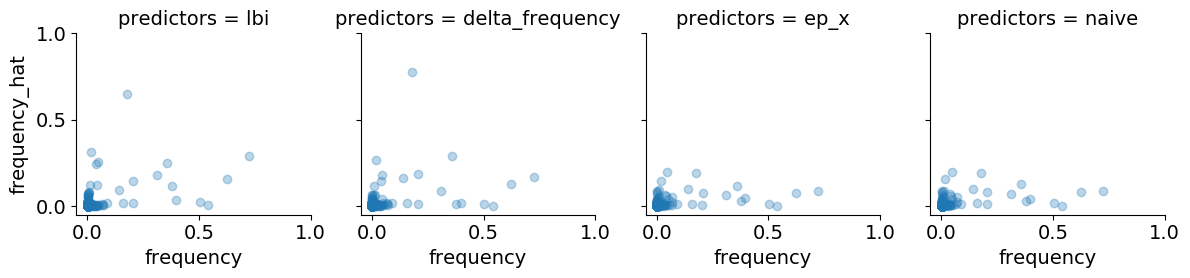

In [649]:
g = sns.FacetGrid(frequency_df, col="predictors", col_wrap=4)
g.map(plt.plot, "frequency", "frequency_hat", marker="o", linestyle="", alpha=0.3)

for ax in g.axes.flatten():
    ax.set_xlim(-0.05, 1)
    ax.set_ylim(-0.05, 1)

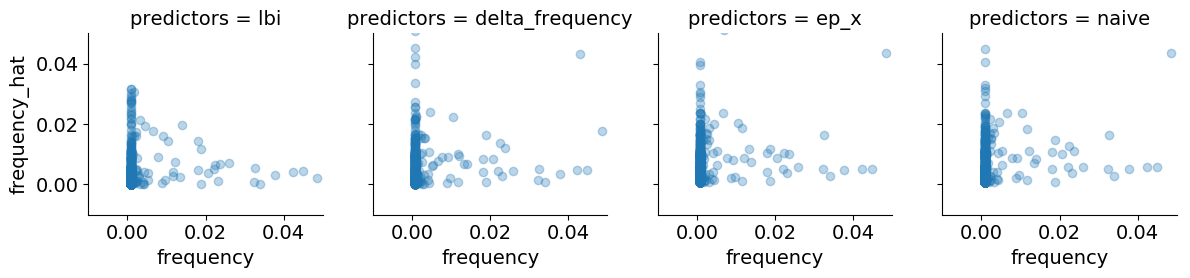

In [650]:
g = sns.FacetGrid(frequency_df, col="predictors", col_wrap=4)
g.map(plt.plot, "frequency", "frequency_hat", marker="o", linestyle="", alpha=0.3)

for ax in g.axes.flatten():
    ax.set_xlim(-0.01, 0.05)
    ax.set_ylim(-0.01, 0.05)

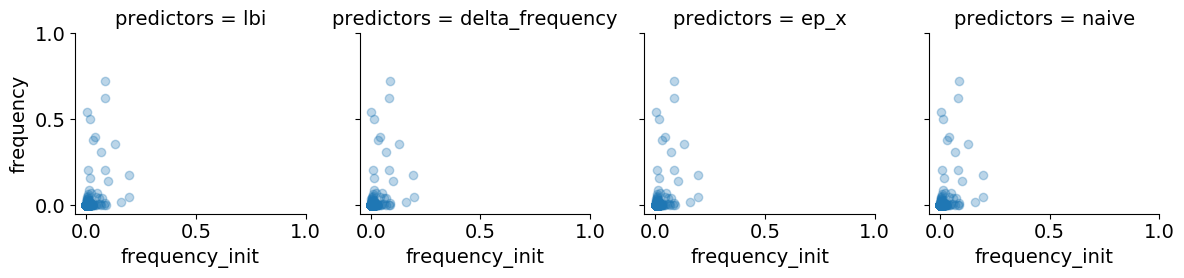

In [651]:
g = sns.FacetGrid(frequency_df, col="predictors", col_wrap=4)
g.map(plt.plot, "frequency_init", "frequency", marker="o", linestyle="", alpha=0.3)

for ax in g.axes.flatten():
    ax.set_xlim(-0.05, 1)
    ax.set_ylim(-0.05, 1)

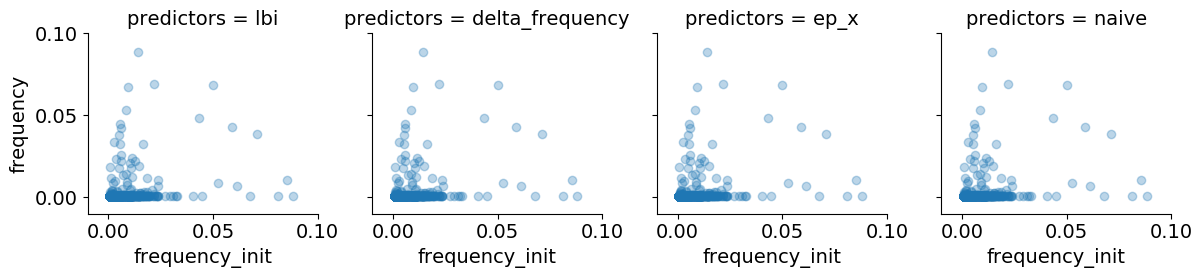

In [652]:
g = sns.FacetGrid(frequency_df, col="predictors", col_wrap=4)
g.map(plt.plot, "frequency_init", "frequency", marker="o", linestyle="", alpha=0.3)

for ax in g.axes.flatten():
    ax.set_xlim(-0.01, 0.1)
    ax.set_ylim(-0.01, 0.1)

In [653]:
frequency_df[frequency_df["predictors"] == "lbi"]["frequency"].shape

(1380,)

In [654]:
(frequency_df[frequency_df["predictors"] == "lbi"]["frequency"] == 0.0).sum()

0

In [655]:
(frequency_df[frequency_df["predictors"] == "lbi"]["frequency_init"] < 0.01).sum()

1218

In [656]:
(frequency_df[frequency_df["predictors"] == "lbi"]["frequency_init"] < 0.01).sum() / frequency_df[frequency_df["predictors"] == "lbi"]["frequency"].shape

array([0.8826087])

In [657]:
(frequency_df[frequency_df["predictors"] == "lbi"]["frequency_init"] < 0.05).sum()

1362

In [658]:
(frequency_df[frequency_df["predictors"] == "lbi"]["frequency_init"] < 0.05).sum() / frequency_df[frequency_df["predictors"] == "lbi"]["frequency"].shape

array([0.98695652])

### Observed and predicted growth rates

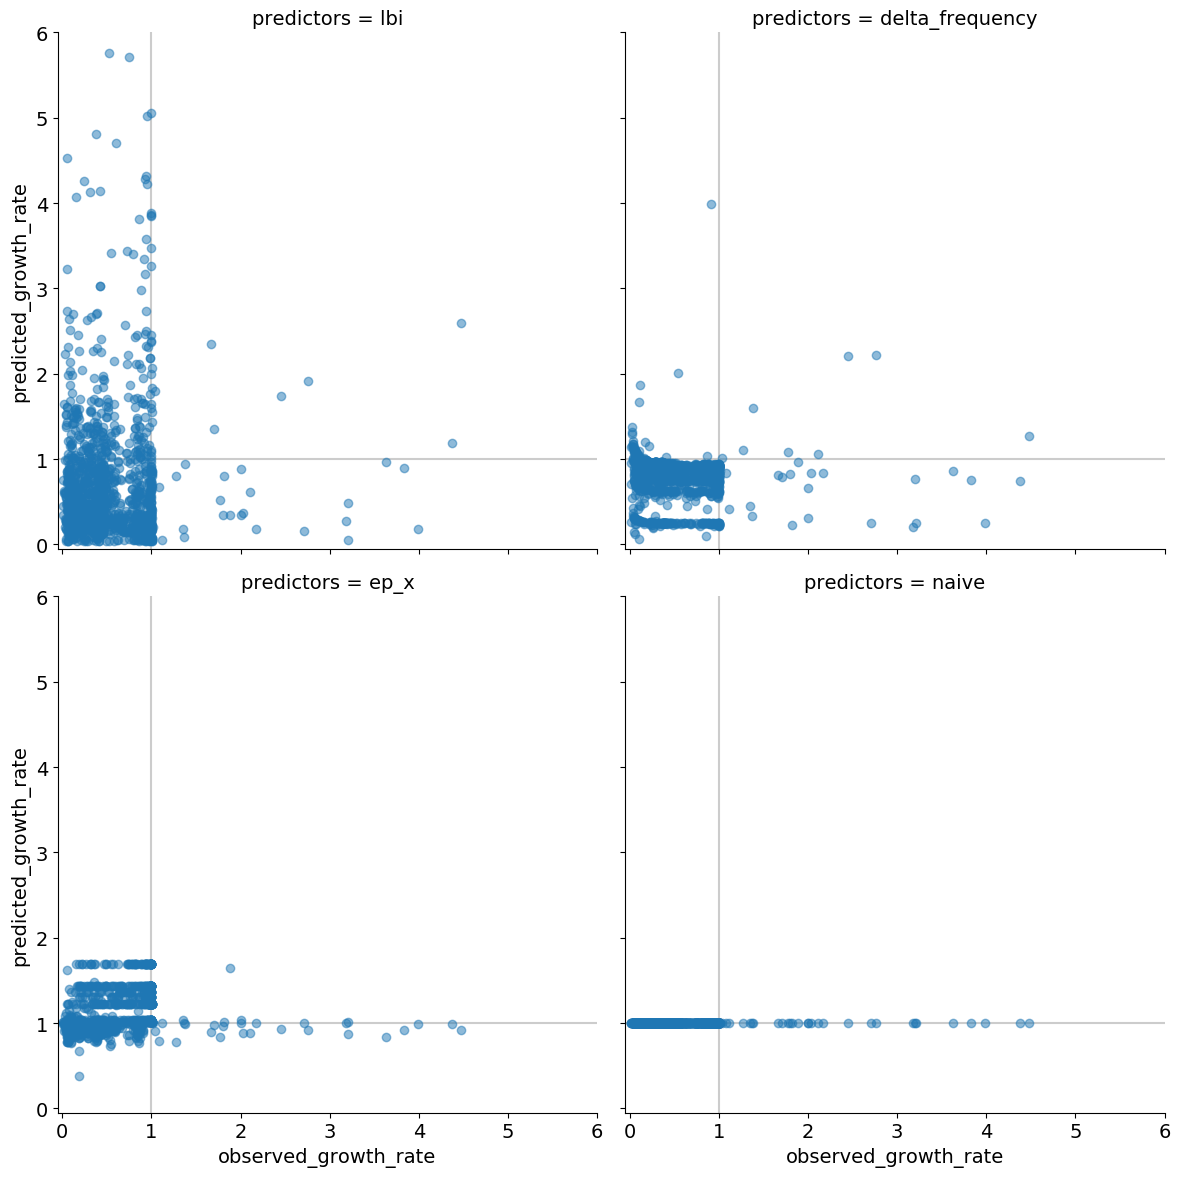

In [659]:
g = sns.FacetGrid(frequency_df, col="predictors", col_wrap=2, height=6, aspect=1.)
g.map(plt.plot, "observed_growth_rate", "predicted_growth_rate", marker="o", linestyle="", alpha=0.5)

for ax in g.axes.flatten():
    ax.axhline(y=1.0, color="#cccccc", zorder=-10)
    ax.axvline(x=1.0, color="#cccccc", zorder=-10)
    ax.set_xlim(-0.05, 6)
    ax.set_ylim(-0.05, 6)

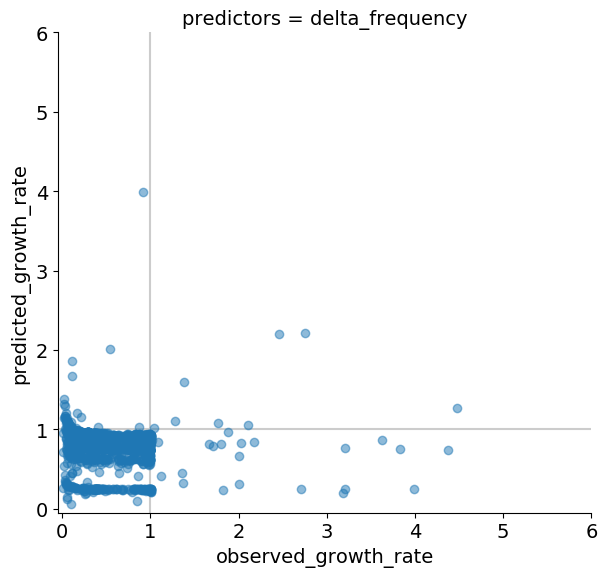

In [660]:
g = sns.FacetGrid(frequency_df[frequency_df["predictors"] == "delta_frequency"], col="predictors", col_wrap=2, height=6, aspect=1.)
g.map(plt.plot, "observed_growth_rate", "predicted_growth_rate", marker="o", linestyle="", alpha=0.5)

for ax in g.axes.flatten():
    ax.axhline(y=1.0, color="#cccccc", zorder=-10)
    ax.axvline(x=1.0, color="#cccccc", zorder=-10)
    ax.set_xlim(-0.05, 6)
    ax.set_ylim(-0.05, 6)

In [661]:
frequency_df.head()

,clade_membership,frequency,timepoint,frequency_hat,frequency_init,residual,observed_growth_rate,predicted_growth_rate,validation_timepoint,predictors
0,00979d7,0.000864,2011-10-01,0.001833,0.011696,-0.000969,0.073863,0.156694,2011-10-01,lbi
1,00ca740,0.000864,2011-10-01,0.000415,0.002161,0.000449,0.399711,0.191986,2011-10-01,lbi
2,026e392,0.000864,2011-10-01,0.000091,0.002260,0.000773,0.382266,0.040373,2011-10-01,lbi
3,07a7c8d,0.000864,2011-10-01,0.000524,0.002218,0.000340,0.389510,0.236214,2011-10-01,lbi
4,09bc0a2,0.000864,2011-10-01,0.000433,0.005583,0.000431,0.154727,0.077541,2011-10-01,lbi


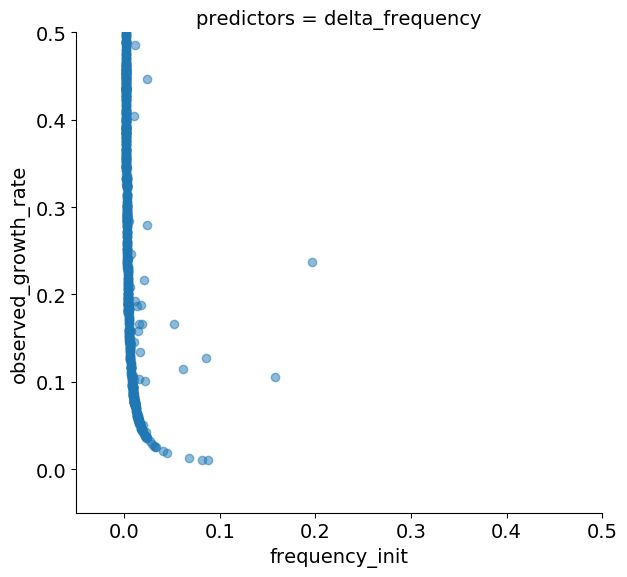

In [662]:
g = sns.FacetGrid(frequency_df[frequency_df["predictors"] == "delta_frequency"], col="predictors", col_wrap=2, height=6, aspect=1.)
g.map(plt.plot, "frequency_init", "observed_growth_rate", marker="o", linestyle="", alpha=0.5)

for ax in g.axes.flatten():
    ax.axhline(y=1.0, color="#cccccc", zorder=-10)
    ax.axvline(x=1.0, color="#cccccc", zorder=-10)
    ax.set_xlim(-0.05, 0.5)
    ax.set_ylim(-0.05, 0.5)

In [663]:
frequency_df.loc[frequency_df["observed_growth_rate"].idxmax()]

clade_membership                     66a66dd
frequency                           0.540829
timepoint                2012-10-01 00:00:00
frequency_hat                     0.00425423
frequency_init                    0.00256209
residual                            0.536575
observed_growth_rate                  211.09
predicted_growth_rate                1.66046
validation_timepoint     2012-10-01 00:00:00
predictors                               lbi
Name: 481, dtype: object

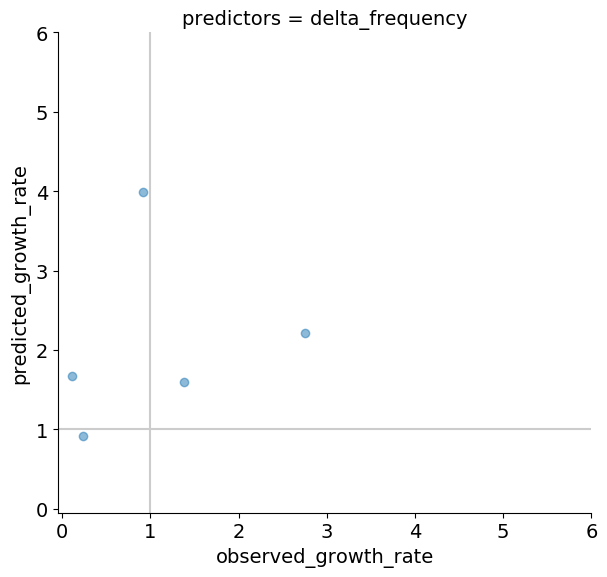

In [664]:
g = sns.FacetGrid(frequency_df[(frequency_df["predictors"] == "delta_frequency") & (frequency_df["frequency_init"] > 0.1)], col="predictors", col_wrap=2, height=6, aspect=1.)
g.map(plt.plot, "observed_growth_rate", "predicted_growth_rate", marker="o", linestyle="", alpha=0.5)

for ax in g.axes.flatten():
    ax.axhline(y=1.0, color="#cccccc", zorder=-10)
    ax.axvline(x=1.0, color="#cccccc", zorder=-10)
    ax.set_xlim(-0.05, 6)
    ax.set_ylim(-0.05, 6)

## Summarize model forecasting error

### Mean absolute error (MAE)

In [665]:
mae_df = frequency_df.groupby("predictors").apply(
    lambda group_df: mean_absolute_error(group_df["frequency"], group_df["frequency_hat"])
).reset_index().rename(columns={0: "mae"})

In [666]:
mae_df.sort_values("mae")

,predictors,mae
2,lbi,0.006154
0,delta_frequency,0.006210
3,naive,0.006486
1,ep_x,0.006555


In [667]:
mae_by_timepoint_df = frequency_df.groupby(["predictors", "validation_timepoint"]).apply(
    lambda group_df: mean_absolute_error(group_df["frequency"], group_df["frequency_hat"])
).reset_index().rename(columns={0: "mae"})

In [668]:
mae_by_timepoint_df.head()

,predictors,validation_timepoint,mae
0,delta_frequency,2011-10-01,0.008171
1,delta_frequency,2012-04-01,0.005312
2,delta_frequency,2012-10-01,0.006732
3,delta_frequency,2013-04-01,0.004175
4,delta_frequency,2013-10-01,0.007547


In [669]:
naive_mae = mae_by_timepoint_df[mae_by_timepoint_df["predictors"] == "naive"]["mae"].values
for predictor in mae_by_timepoint_df["predictors"].drop_duplicates().values:
    mae_by_timepoint_df.loc[mae_by_timepoint_df["predictors"] == predictor, "adjusted_mae"] =  mae_by_timepoint_df.loc[mae_by_timepoint_df["predictors"] == predictor, "mae"] - naive_mae

In [670]:
mae_df["adjusted_mae"] = mae_df["mae"] - mae_df[mae_df["predictors"] == "naive"]["mae"].iloc[0]

In [671]:
overall_errors_df.head()

,cv_error_mean,cv_error_std,predictors
0,0.245239,0.102856,lbi
1,0.285173,0.127229,delta_frequency
2,0.257153,0.109076,ep_x
3,0.255101,0.109723,naive


(0, 0.007235723382161453)

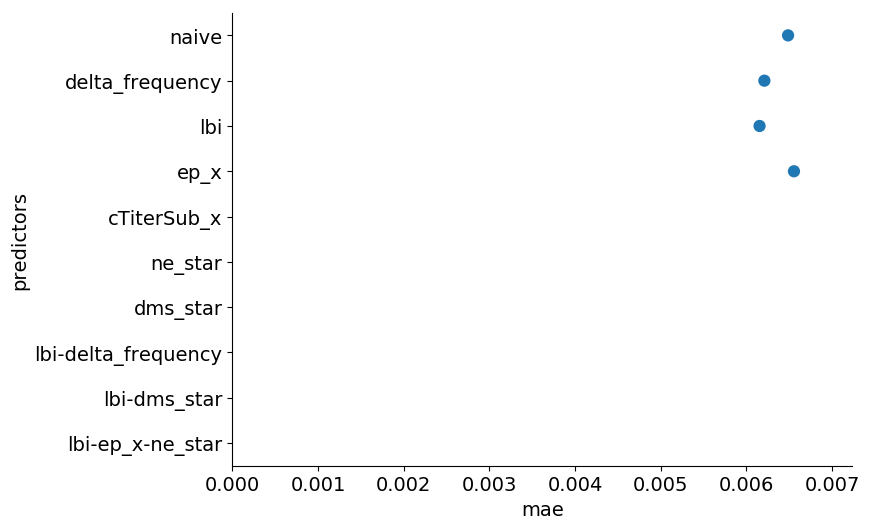

In [672]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(
    x="mae",
    y="predictors",
    data=mae_df,
    join=False,
    order=predictor_names_order,
    ax=ax
)
ax.set_xlim(left=0)

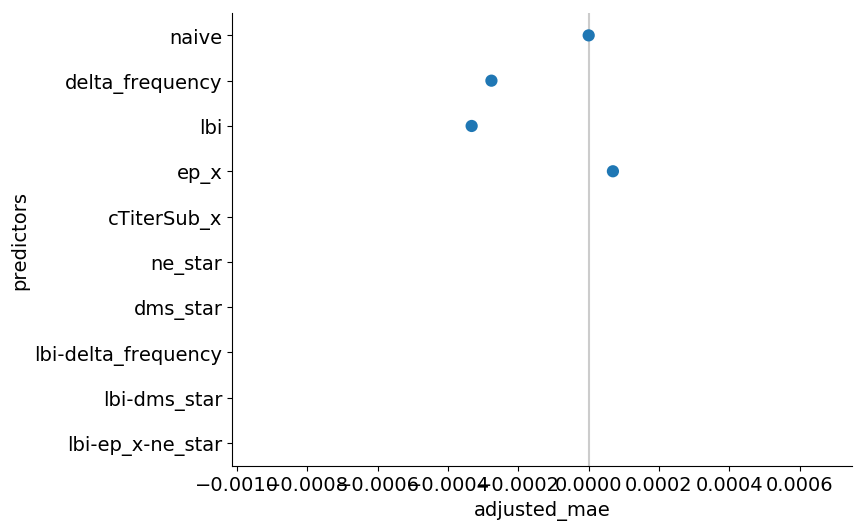

In [673]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(
    x="adjusted_mae",
    y="predictors",
    data=mae_df,
    join=False,
    order=predictor_names_order,
    ax=ax
)
ax.axvline(x=0.0, color="#cccccc", zorder=-10)
#ax.set_xlim(left=0)

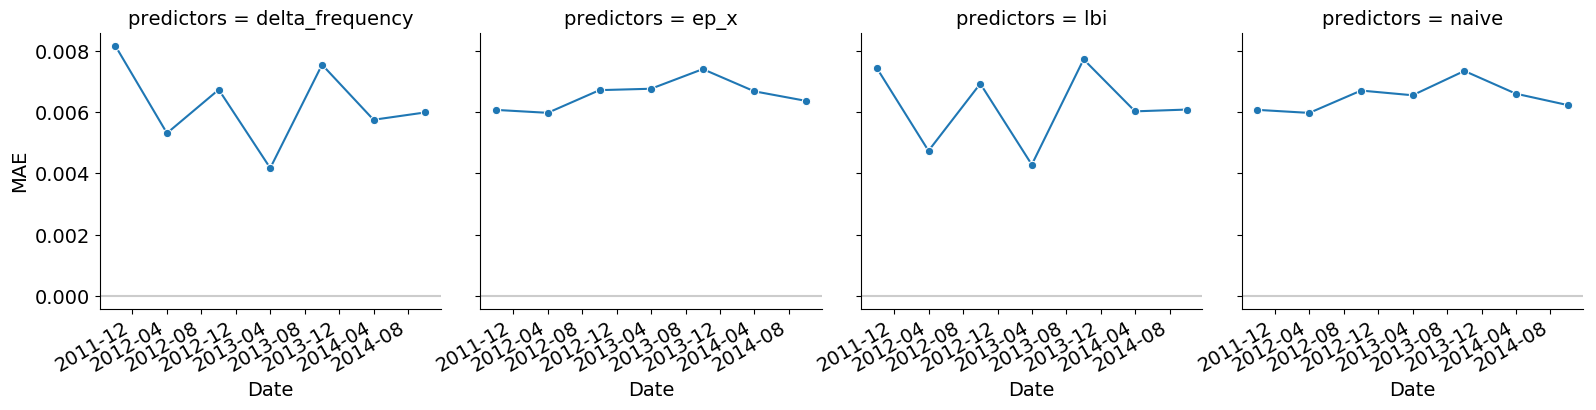

In [674]:
g = facet_time_plot(mae_by_timepoint_df, "mae", "MAE", timepoint_column="validation_timepoint")

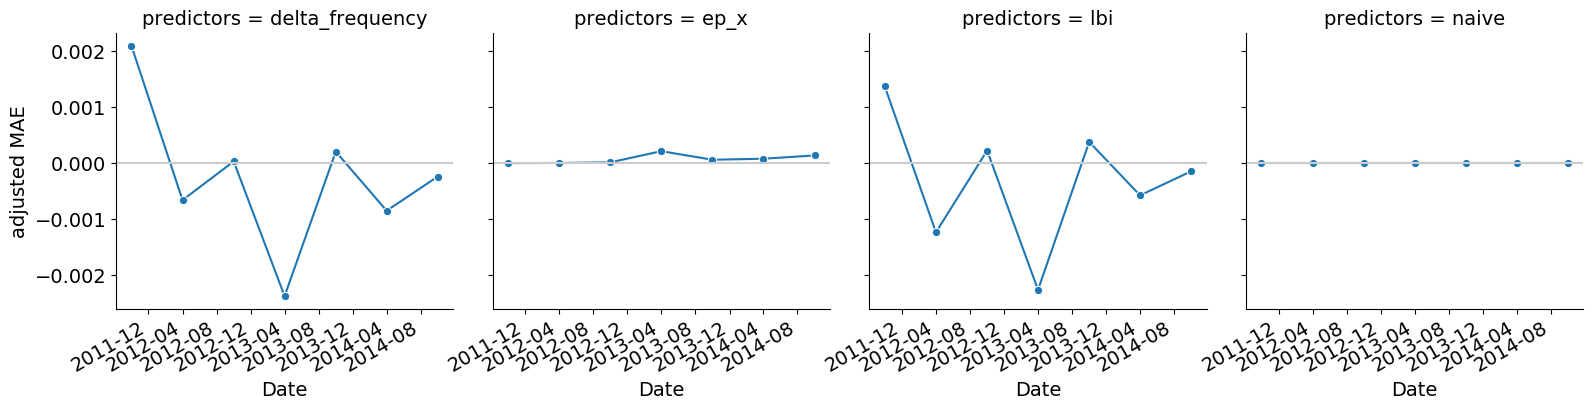

In [675]:
g = facet_time_plot(mae_by_timepoint_df, "adjusted_mae", "adjusted MAE", timepoint_column="validation_timepoint")

### Root mean square error (RMSE)

In [676]:
rmse_df = frequency_df.groupby("predictors").apply(
    lambda group_df: root_mean_square_error(group_df["frequency"], group_df["frequency_hat"])
).reset_index().rename(columns={0: "rmse"})

In [677]:
rmse_df.sort_values("rmse")

,predictors,rmse
2,lbi,0.035270
3,naive,0.035972
1,ep_x,0.036116
0,delta_frequency,0.038033


In [678]:
rmse_by_timepoint_df = frequency_df.groupby(["predictors", "validation_timepoint"]).apply(
    lambda group_df: root_mean_square_error(group_df["frequency"], group_df["frequency_hat"])
).reset_index().rename(columns={0: "rmse"})

In [679]:
naive_rmse = rmse_by_timepoint_df[rmse_by_timepoint_df["predictors"] == "naive"]["rmse"].values
for predictor in rmse_by_timepoint_df["predictors"].drop_duplicates().values:
    rmse_by_timepoint_df.loc[rmse_by_timepoint_df["predictors"] == predictor, "adjusted_rmse"] =  rmse_by_timepoint_df.loc[rmse_by_timepoint_df["predictors"] == predictor, "rmse"] - naive_rmse

In [680]:
rmse_df["adjusted_rmse"] = rmse_df["rmse"] - rmse_df[rmse_df["predictors"] == "naive"]["rmse"].iloc[0]

(0, 0.038831853414551615)

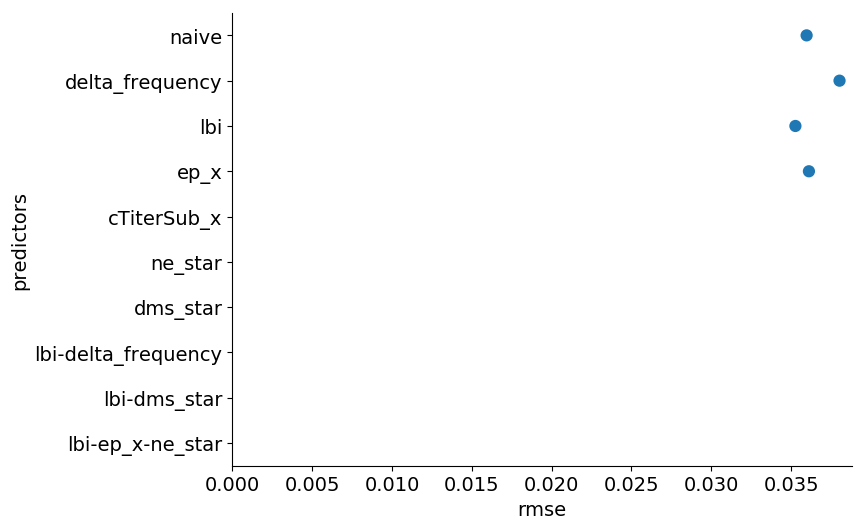

In [681]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(
    x="rmse",
    y="predictors",
    data=rmse_df,
    join=False,
    order=predictor_names_order,
    ax=ax
)
ax.set_xlim(left=0)

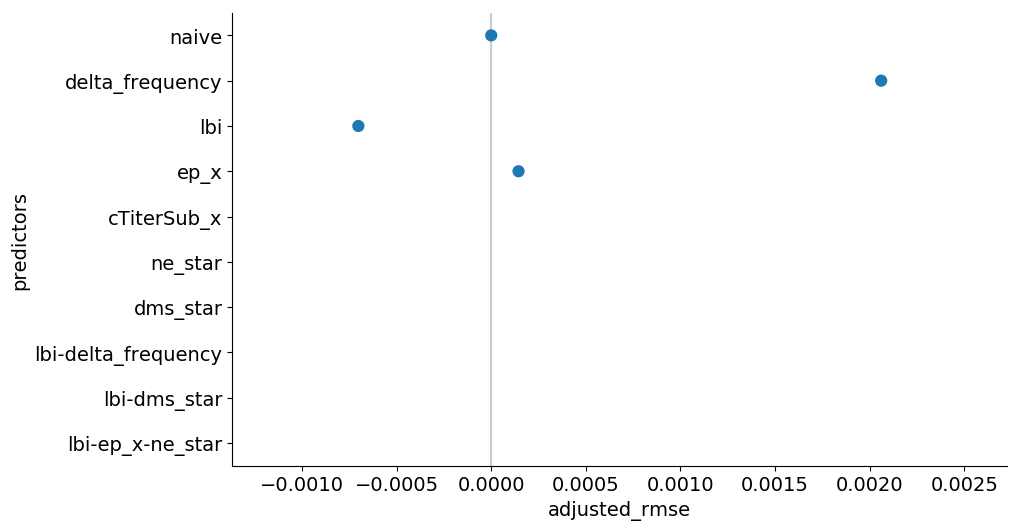

In [682]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.pointplot(
    x="adjusted_rmse",
    y="predictors",
    data=rmse_df,
    join=False,
    order=predictor_names_order,
    ax=ax
)
ax.axvline(x=0.0, color="#cccccc", zorder=-10)
#ax.set_xlim(left=0)

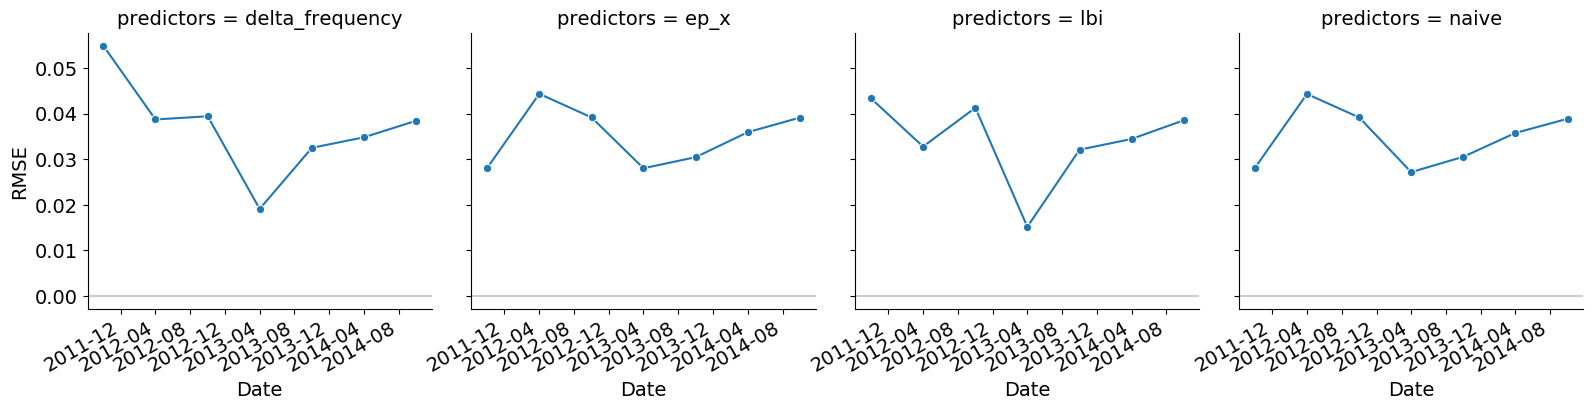

In [683]:
g = facet_time_plot(rmse_by_timepoint_df, "rmse", "RMSE", timepoint_column="validation_timepoint")

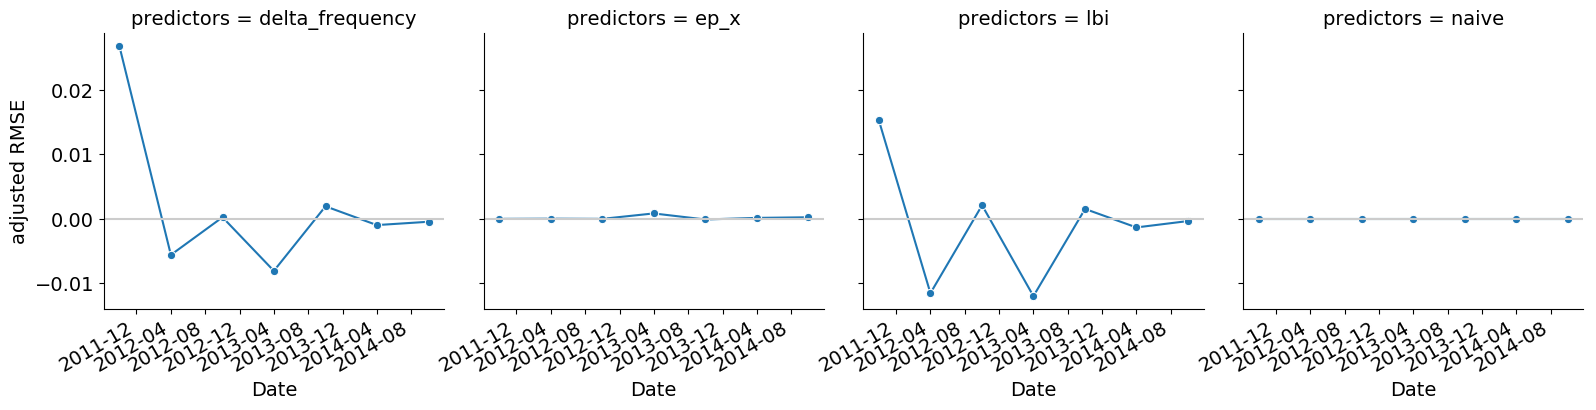

In [684]:
g = facet_time_plot(rmse_by_timepoint_df, "adjusted_rmse", "adjusted RMSE", timepoint_column="validation_timepoint")

### Mean squared error (MSE)

In [685]:
mse_df = frequency_df.groupby("predictors").apply(
    lambda group_df: mean_square_error(group_df["frequency"], group_df["frequency_hat"])
).reset_index().rename(columns={0: "mse"})

In [686]:
mse_by_timepoint_df = frequency_df.groupby(["predictors", "validation_timepoint"]).apply(
    lambda group_df: mean_square_error(group_df["frequency"], group_df["frequency_hat"])
).reset_index().rename(columns={0: "mse"})

In [687]:
naive_mse = mse_by_timepoint_df[mse_by_timepoint_df["predictors"] == "naive"]["mse"].values
for predictor in mse_by_timepoint_df["predictors"].drop_duplicates().values:
    mse_by_timepoint_df.loc[mse_by_timepoint_df["predictors"] == predictor, "adjusted_mse"] =  mse_by_timepoint_df.loc[mse_by_timepoint_df["predictors"] == predictor, "mse"] - naive_mse

(0, 0.0021170734387630334)

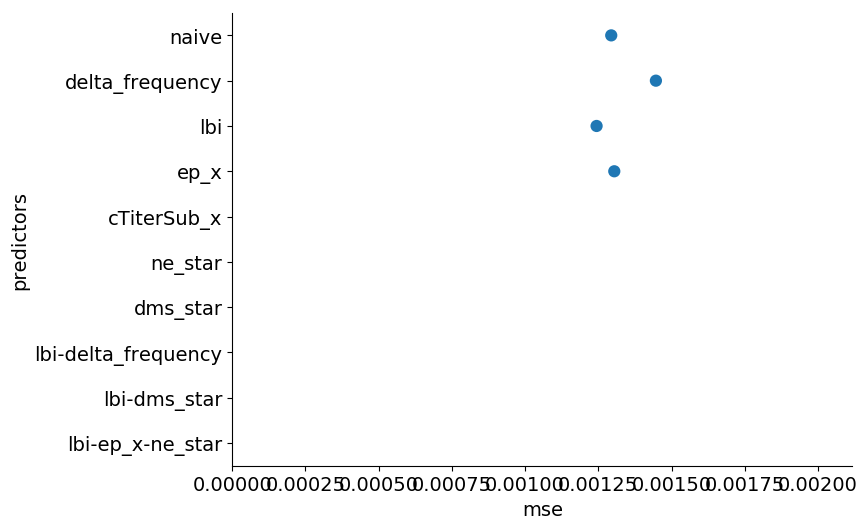

In [688]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(
    x="mse",
    y="predictors",
    data=mse_df,
    join=False,
    order=predictor_names_order,
    ax=ax
)
ax.set_xlim(left=0)

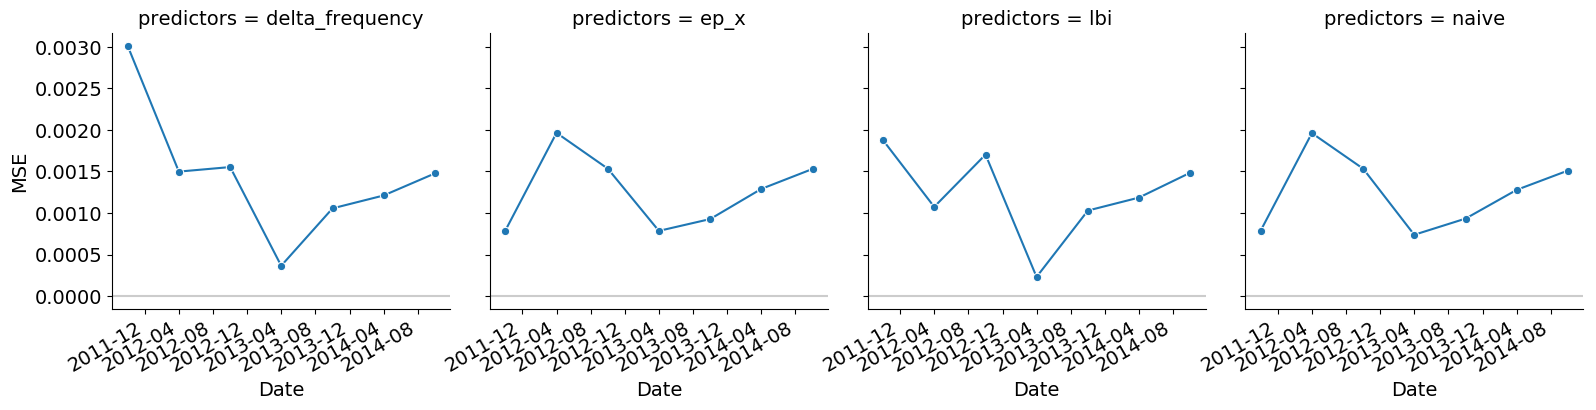

In [689]:
g = facet_time_plot(mse_by_timepoint_df, "mse", "MSE", timepoint_column="validation_timepoint")

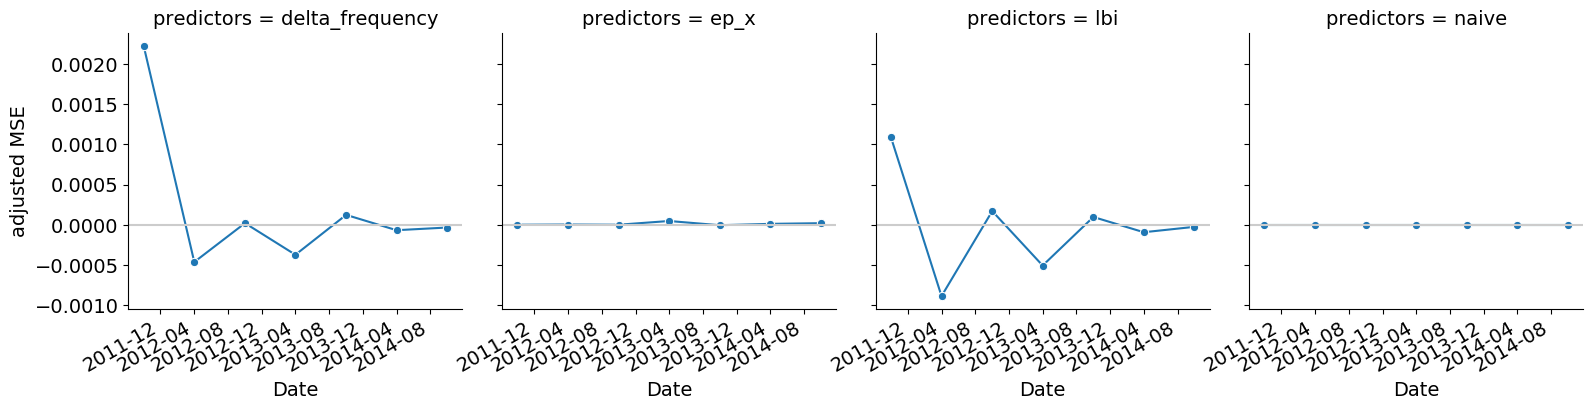

In [690]:
g = facet_time_plot(mse_by_timepoint_df, "adjusted_mse", "adjusted MSE", timepoint_column="validation_timepoint")

(0.0, 0.0031717144378121628)

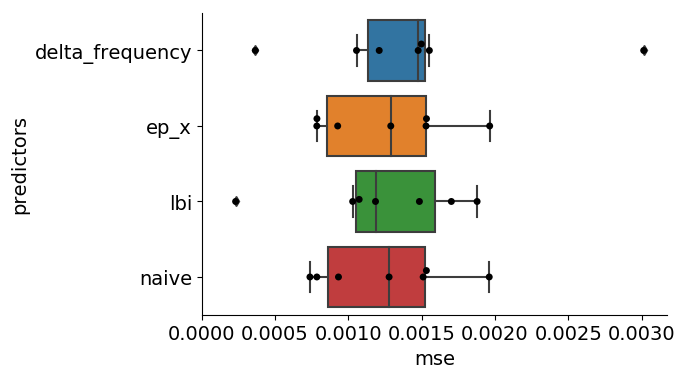

In [691]:
ax = sns.boxplot(
    "mse",
    "predictors",
    data=mse_by_timepoint_df
)
ax = sns.swarmplot(
    "mse",
    "predictors",
    data=mse_by_timepoint_df,
    color="black",
    ax=ax
)
ax.set_xlim(left=0.0)

## Summarize model coefficients

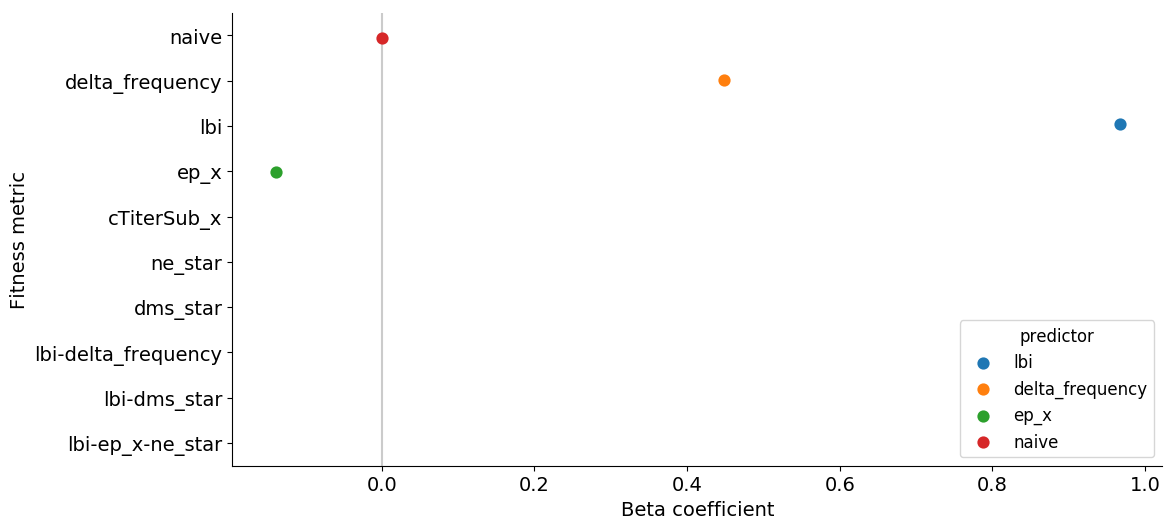

In [692]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.pointplot(
    y="predictors",
    x="mean",
    hue="predictor",
    data=overall_coefficients_df,
    ax=ax,
    dodge=True,
    join=False,
    order=predictor_names_order
)

ax.axvline(0, color="#999999", alpha=0.5, zorder=-10)
ax.set_xlabel("Beta coefficient")
ax.set_ylabel("Fitness metric")

sns.despine()

In [693]:
coefficients_by_time_df.head()

,coefficient,predictor,predictors,validation_timepoint
0,1.088881,lbi,lbi,2011-10-01
1,0.986556,lbi,lbi,2012-04-01
2,0.867304,lbi,lbi,2012-10-01
3,0.993097,lbi,lbi,2013-04-01
4,0.920804,lbi,lbi,2013-10-01


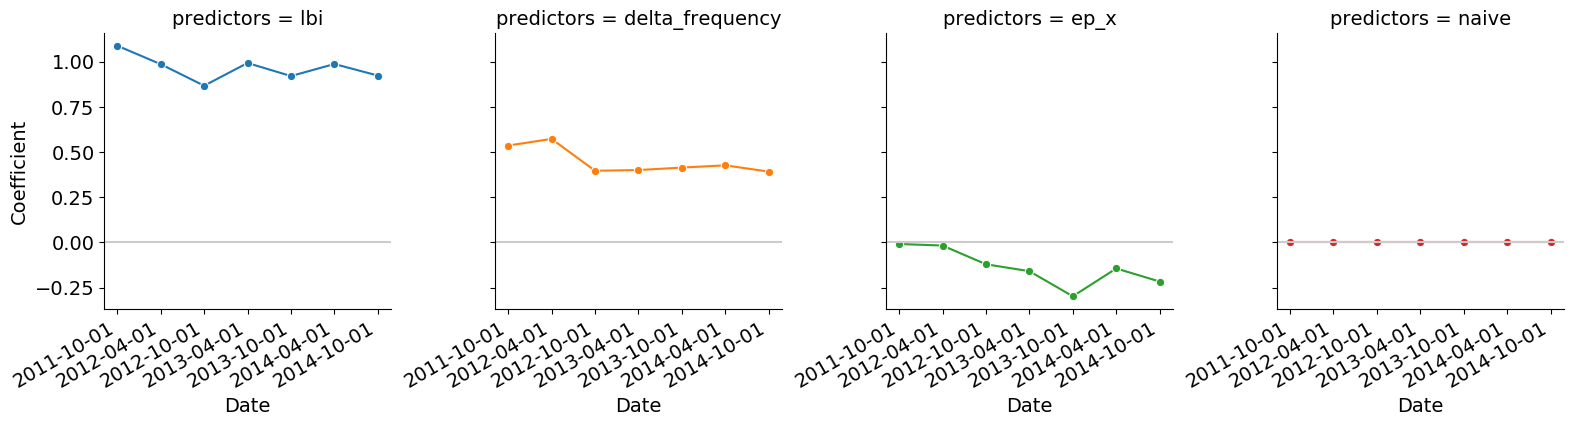

In [694]:
g = facet_time_plot(coefficients_by_time_df, "coefficient", "Coefficient", timepoint_column="validation_timepoint", hue="predictor")

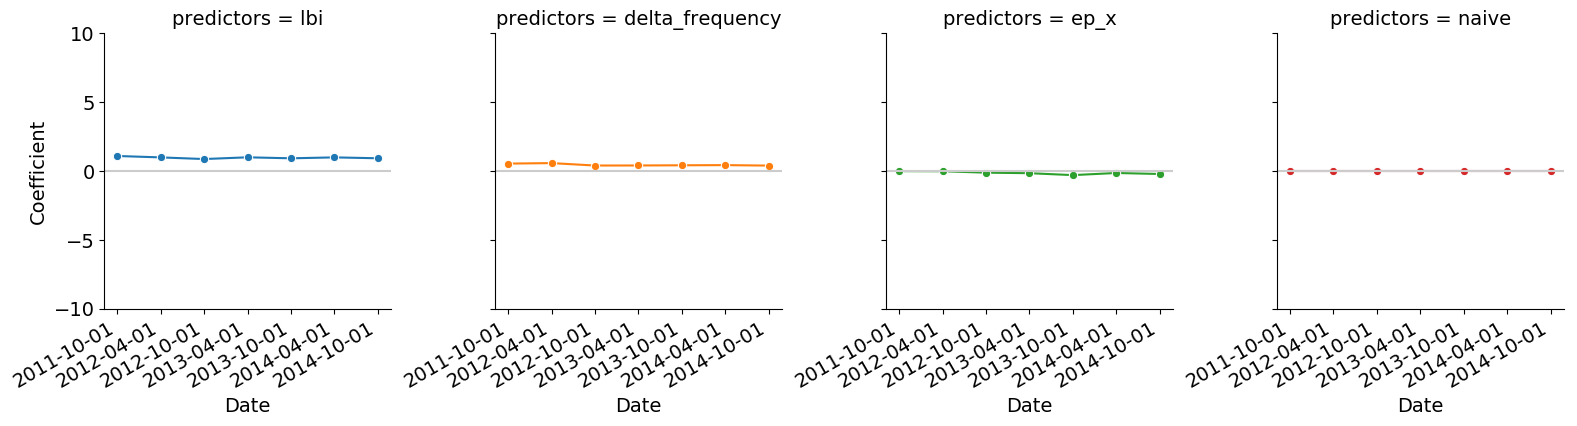

In [695]:
g = facet_time_plot(coefficients_by_time_df, "coefficient", "Coefficient", timepoint_column="validation_timepoint", hue="predictor")

for ax in g.axes.flatten():
    ax.set_ylim(-10, 10)

In [696]:
np.random.normal(scale=2.0)

-1.963180427509527